<a href="https://colab.research.google.com/github/Musyfy/AI_FIN_823/blob/master/LSTM_with_Hyperas_Auto_Tuning_for_stock_price_prediction_DIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import numpy as np
import pandas as pd
import quandl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm
import dask.dataframe as dd
import tensorflow as tf
import sys

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout, CuDNNLSTM, CuDNNGRU, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.optimizers import Adam, SGD, Nadam
from keras.layers.normalization import BatchNormalization
from time import time
from keras.layers.advanced_activations import LeakyReLU, PReLU
#from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras import backend as K

#from livelossplot import PlotLossesKeras
from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.client import device_lib
from keras import backend as K
from keras import metrics
from keras.utils import np_utils
import keras as ks
import pickle
import os

import pandas_datareader.data as pd_reader
import warnings
warnings.filterwarnings("ignore")

In [0]:
#pip install quandl

In [0]:
#pip install hyperas

In [7]:
from google.colab import drive
drive.mount('/gdrive')
%ls /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
'My Drive'/


In [8]:
!ls '/gdrive/My Drive/Colab Notebooks'

'LSTM with Hyperas - Auto Tuning for stock price prediction - AT&T.ipynb'
'LSTM with Hyperas - Auto Tuning for stock price prediction - BAC.ipynb'
'LSTM with Hyperas - Auto Tuning for stock price prediction - BACV2.ipynb'
'LSTM with Hyperas - Auto Tuning for stock price prediction-Copy1.ipynb'
'LSTM with Hyperas - Auto Tuning for stock price prediction - DIS.ipynb'
'LSTM with Hyperas - Auto Tuning for stock price prediction - MA.ipynb'
'LSTM with Hyperas - Auto Tuning for stock price prediction - PG.ipynb'
'LSTM with Hyperas - Auto Tuning for stock price prediction - UNH.ipynb'
'LSTM with Hyperas - Auto Tuning for stock price prediction - Visa.ipynb'
'LSTM with Hyperas - Auto Tuning for stock price prediction - XOM.ipynb'
 Untitled0.ipynb
 Untitled1.ipynb


In [0]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)

In [0]:
#conda install -c delichon pandas_datareader

In [10]:
from platform import python_version
print(python_version())

3.6.9


In [0]:
#pip install hyperas

In [0]:
quandl.ApiConfig.api_key = "uRMo697HgMj91ZZZa2_v"
df = quandl.get_table('WIKI/PRICES', qopts = { 'columns': ['ticker', 'date', 'adj_close','open','high','low','close'] }, ticker = ['DIS'], date = { 'gte': '2009-01-01', 'lte': '2019-12-19' })
df = pd_reader.DataReader('DIS','yahoo')

In [0]:
from hyperas.distributions import uniform

from hyperopt import Trials, STATUS_OK, tpe
from keras.datasets import mnist
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils

from hyperas import optim
from hyperas.distributions import choice, uniform

### Make sure to edit your stock ticker in def data()

In [0]:
def data():
    ###maka sure to change the stock ticker here 
    quandl.ApiConfig.api_key = "uRMo697HgMj91ZZZa2_v"
    df = quandl.get_table('WIKI/PRICES', qopts = { 'columns': ['ticker', 'date', 'adj_close','open','high','low','close'] }, ticker = ['DIS'], date = { 'gte': '2009-01-01', 'lte': '2019-12-19' })
    df = pd_reader.DataReader('DIS','yahoo')
    df = df[['Adj Close','High','Open','Close','Low']] 
    df = df.dropna()
    
    factor_ratio = 0.7
    df1 = df.iloc[:round(len(df)*factor_ratio)]
    df2 = df[round(len(df)*factor_ratio):]
    
    training_set = df1.iloc[:,0:].values
    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(training_set)
    
    #train set
    X_train = []
    y_train = []
    for i in range(45, len(training_set_scaled)):
        X_train.append(training_set_scaled[i-45:i])
        y_train.append(training_set_scaled[i,0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 5))
    
    #test set
    y_test = df2.iloc[:,0:1].values

    dataset_total = df.iloc[:,0:]
    inputs = dataset_total[len(dataset_total) - len(df2) -45:].values
    inputs = sc.fit_transform(inputs)

    X_test = []
    for i in range(45, len(inputs)):
        X_test.append(inputs[i-45:i])
    
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))
    
    return X_train, y_train, X_test, y_test

In [0]:
X_train, y_train, X_test, y_test = data()

### Things to consider 
1. create_model function: Change epochs to a lower number in the beginning
2. create_model function: Start with lower number of layers - 4 was the best for me 
3. create_model function: The number of hidden layers is still to be tuned manually 
4. create_model function: if you are to add more layers. Make sure that the last layer is always set to (return_sequence=False) 
5. create_model function: you can add more parameters to tune: such as activation function, add more optimizers, or change dropout rate to a range between 0 & 1. 
6. if __name__ == '__main__' function: Make sure notebook_name matches the name of your notebook, otherwise it doesn't run. not sure how it would work on pycharm (you can try to remove this parameter) 
7. if __name__ == '__main__' function: you can change the number of max_eval to a lower number if you want this to run faster. This parameter is similar to a random search, and  will give you different models based on the max_eval number chosen. 3 or 4 should be okay with what I have seen so far. 

**This will take time if you are running it on your local machine**

In [0]:
def create_model(X_train, y_train, X_test, y_test): 
    """
    Model providing function:

    Create Keras model with double curly brackets dropped-in as needed.
    Return value has to be a valid python dictionary with two customary keys:
        - loss: Specify a numeric evaluation metric to be minimized
        - status: Just use STATUS_OK and see hyperopt documentation if not feasible
    The last one is optional, though recommended, namely:
        - model: specify the model just created so that we can later use it again.
    """
      
    model = Sequential()
    model.add(LSTM(units={{choice([100, 200, 300])}}, input_shape=(45,5), return_sequences= True))
    model.add(Dropout(rate={{uniform(0.2, 0.5)}}))
    
    model.add(LSTM(units={{choice([100, 200, 300])}}, return_sequences= True))
    model.add(Dropout(rate={{uniform(0.2, 0.5)}}))
    
    model.add(LSTM(units={{choice([100, 200, 300])}}, return_sequences= True))
    model.add(Dropout(rate={{uniform(0.2, 0.5)}}))
    
    model.add(LSTM(units={{choice([100, 200, 300])}}, return_sequences= False))
    model.add(Dropout(rate={{uniform(0.2, 0.5)}}))
    
    #model.add(LSTM(units={{choice([100, 200, 300])}}, return_sequences= False))
    #model.add(Dropout(rate={{uniform(0.2, 0.5)}}))
    
    #model.add(LSTM(units={{choice([100, 200, 300])}}, return_sequences= False))
    #model.add(Dropout(rate={{uniform(0.2, 0.5)}}))
    
    #model.add(LSTM(units={{choice([100, 200, 300])}}))
    #model.add(Dropout(rate={{uniform(0.2, 0.5)}}))
    
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error',
                  optimizer={{choice(['adam', 'sgd'])}})

    model.summary()

    result = model.fit(X_train, y_train,
              batch_size={{choice([100,50,80,200])}},
              epochs=100, verbose=2)
    #get the highest validation accuracy of the training epochs
    validation_error = np.amin(result.history['loss']) 
    print('Best validation error of epoch:', validation_error)
    return {'loss': -validation_error, 'status': STATUS_OK, 'model': model}

In [16]:
if __name__ == '__main__':
    best_run, best_model = optim.minimize(model=create_model,
                                    data=data,
                                    algo=tpe.suggest,
                                    max_evals=4,
                                    trials=Trials(),
                                    notebook_name= os.path.join('..','gdrive','My Drive','Colab Notebooks','LSTM with Hyperas - Auto Tuning for stock price prediction - DIS'))
    X_train, Y_train, X_test, Y_test = data()
    print("Evalutation of best performing model:")
    print(best_model)
    print("Best performing model chosen hyper-parameters:")
    print(best_run)

>>> Imports:
#coding=utf-8

from __future__ import print_function

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import quandl
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from mpl_toolkits.mplot3d import Axes3D
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    from tqdm import tqdm
except:
    pass

try:
    import dask.dataframe as dd
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    import sys
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers.core import Dense, Activation, Dropout, Flatten
except:
    pass

try:
    from keras.layers.recurrent import LSTM
except:
    pass

try:
    from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout, CuDNNLSTM, CuDNNGRU, Conv2D, MaxPooling2D
except:
    pass

try:
    from keras.callbacks import EarlyStopping, TensorBoard, Model

In [17]:
best_run

{'batch_size': 2,
 'optimizer': 0,
 'rate': 0.21219197235527482,
 'rate_1': 0.49911883690731396,
 'rate_2': 0.4112992742254813,
 'rate_3': 0.4287674478496333,
 'rate_4': 0.4074604059830311,
 'rate_5': 0.46008729853372504,
 'rate_6': 0.4915577688323514,
 'units': 0,
 'units_1': 2,
 'units_2': 1,
 'units_3': 0,
 'units_4': 2,
 'units_5': 2,
 'units_6': 1}

In [18]:
best_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 45, 100)           42400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 45, 100)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 45, 300)           481200    
_________________________________________________________________
dropout_10 (Dropout)         (None, 45, 300)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 45, 200)           400800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 45, 200)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)              

## Make sure to edit your stock ticker again in the next cell

In [0]:
##maka sure to change the stock ticker here 
quandl.ApiConfig.api_key = "uRMo697HgMj91ZZZa2_v"
df = quandl.get_table('WIKI/PRICES', qopts = { 'columns': ['ticker', 'date', 'adj_close','open','high','low','close'] }, ticker = ['DIS'], date = { 'gte': '2009-01-01', 'lte': '2019-12-19' })
df = pd_reader.DataReader('DIS','yahoo')
df = df[['Adj Close','High','Open','Close','Low']]
df = df.dropna()
    
factor_ratio = 0.7
df1 = df.iloc[:round(len(df)*factor_ratio)]
df2 = df[round(len(df)*factor_ratio):]
    
training_set = df1.iloc[:,0:].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)


In [0]:
real_stock_price = df2.iloc[:,0:1].values

dataset_total = df.iloc[:,0:]

inputs = dataset_total[len(dataset_total) - len(df2) -45:].values
#inputs = inputs.reshape(-1,1)
inputs = sc.fit_transform(inputs)

X_test = []
for i in range(45, len(inputs)):
    X_test.append(inputs[i-45:i])

In [0]:
X_test = np.array(X_test)

In [22]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))
X_test.shape

(758, 45, 5)

In [23]:
predicted_stock_price= best_model.predict(X_test)
sc.fit_transform(real_stock_price)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price = pd.DataFrame(predicted_stock_price,columns=['adj_close'])
predicted_stock_price.reset_index(inplace=True)
predicted_stock_price = predicted_stock_price[['adj_close']]
data_test = df[round(len(df)*factor_ratio):]
data_test.reset_index(inplace=True)
data_test = data_test[["Date"]]

final = pd.merge(data_test, predicted_stock_price, left_index=True, right_index=True)
final.head()

,Date,adj_close
0,2017-01-13,106.336983
1,2017-01-17,106.533737
2,2017-01-18,106.590538
3,2017-01-19,106.552277
4,2017-01-20,106.447083


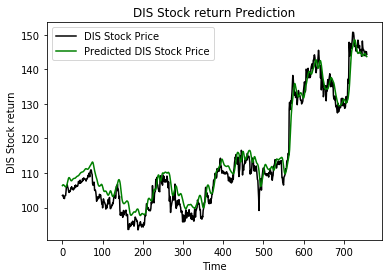

In [24]:
plt.plot(real_stock_price, color = 'black', label = 'DIS Stock Price')
plt.plot(predicted_stock_price['adj_close'], color = 'green', label = 'Predicted DIS Stock Price')
plt.title('DIS Stock return Prediction')
plt.xlabel('Time')
plt.ylabel('DIS Stock return')
plt.legend()
plt.show()

In [0]:
import pickle
with open('DIS_model.pickle','wb') as f:
    pickle.dump(best_model,f)

with open('DIS_model.pickle','rb') as f:
    model = pickle.load(f)

In [0]:
from google.colab import files
files.download('DIS_model.pickle') 